# 實驗2: One 2d Gaussian SDE and ODE 

1D SDE(OU process): 
$$
dX_t = -\beta X_t dt+\sigma dW_t.
$$

Then 2D SDE(OU process):
$$
d\textbf{X}_t=-B(\textbf{X}_t-\mu_{\infty})dt+\Sigma d\textbf{W}_t,
$$
where 
* $\textbf{X}_t=(X^{(1)}_t, X_t^{(2)})^{T}$
* $B:=\beta I$ is an $2\times 2$ drift matrix
* $\Sigma:=\sigma I$ is an $2\times 2$ noise matrix
* $\mu_{\infty}$ 是收斂平均值 as time $\rightarrow \infty$

OU process 始終是2D Gaussian.  
$$X_t\sim\mathcal{N}(m_t,C_t),$$
mean:
$$ m_t= \mu_{\infty}+e^{-\beta t}(m_0-\mu_{\infty}).$$
covariance:
$$ C_t=e^{-2\beta t}C_0+\frac{\sigma^2}{2\beta}(1-e^{-2\beta t})I.$$

※這邊沒有設定$\mu_{\infty}$那就默認是0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [46]:
# ------- 內部畫圖函數 -------
def plot_2d(traj_hist, times, mu0, name):
    S, K, _ = traj_hist.shape

    fig, ax = plt.subplots(figsize=(5,5))

        # 畫每一條 2D 軌跡
    for j in range(K):
        ax.plot(traj_hist[:, j, 0],
                traj_hist[:, j, 1],
                linewidth=1.0, alpha=0.8)

    # 標一下初始點（t=0）與終點（t=T）
    #start_pts = traj_hist[0]      # (K,2)
    #end_pts   = traj_hist[-1]     # (K,2)
    start_pts = traj_hist[0]      # 正確：t=0 snapshots
    end_pts   = traj_hist[-1]     # t=T snapshots

    ax.scatter(start_pts[:,0], start_pts[:,1],
                   s=30, marker="o", edgecolor="k", facecolor="none",
                   label="t=0")
    ax.scatter(end_pts[:,0], end_pts[:,1],
                   s=20, marker="x", color="red",
                   label=f"t={times[-1]:.2f}")

        # 標一下初始 mean 位置
    ax.scatter(mu0[0], mu0[1],
                   s=60, marker="*", color="gold", edgecolor="k",
                   label="mu0")

    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_title(name)
    ax.axis("equal")
    ax.grid(alpha=0.3)
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()


## 1. Forward SDE

In [ ]:
def SDE_forward_2d(beta, sigma, rng,
                   T, dt,
                   mu0, C0,
                   K_traj, N):

    
    # ------- SDE 模擬本體 -------
    steps = int(T/dt)

    # 初始 (N,2) 樣本：X_0 ~ N(mu0, C0)
    x = rng.multivariate_normal(mu0, C0, size=N)   # shape = (N,2)

    traj_hist = [x[:K_traj].copy()]   # 只記前 K_traj 條軌跡
    times = [0.0]

    for i in range(1, steps+1):
        dW = rng.normal(size=(N,2)) * np.sqrt(dt)

        # drift = -beta * x  (逐點作用)
        x = x + (-beta * x) * dt + sigma * dW

        t = i * dt
        if i % max(1, steps//300) == 0:
            traj_hist.append(x[:K_traj].copy())
            times.append(t)

    traj_hist = np.array(traj_hist)   # (S, K, 2)
    times = np.array(times)           # (S,)

    # 呼叫內部畫圖函數
    name="2D Forward OU SDE Trajectories"
    plot_2d(traj_hist, times, mu0, name)

    # 也把資料回傳，之後想再畫別的圖還可以用
    return traj_hist, times


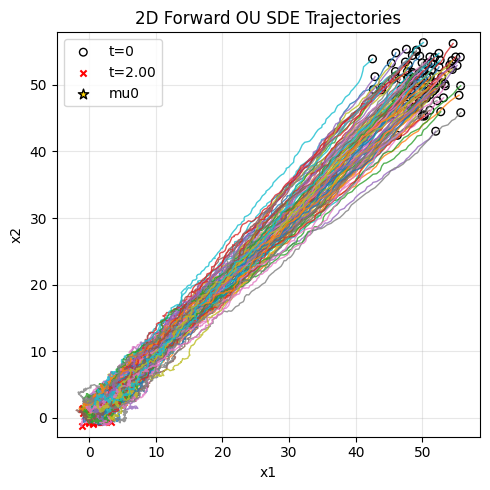

In [66]:
rng = np.random.default_rng(0)

beta  = 2.0
sigma = 2.0
mu0   = np.array([50.0, 50.0])
C0    = np.eye(2) * 10.0

T     = 2
dt    = 5e-3
K_traj = 100
N      = 5000

traj_hist, times = SDE_forward_2d(beta, sigma, rng,
                                  T, dt,
                                  mu0, C0,
                                  K_traj, N)


In [49]:
print("first snapshot mean =", traj_hist[0].mean(axis=0))
print("last  snapshot mean =", traj_hist[-1].mean(axis=0))


first snapshot mean = [49.77222788 51.04361743]
last  snapshot mean = [-0.08204778  0.26710644]


---

## 2. Backward SDE

1D backward: 
$$dX_t = \big[ \beta X_t - \sigma^2 \nabla_x \log p_t(X_t) \big]\,dt + \sigma \, d\bar{W}_t.$$
Then 2D:
$$dX_t
= \Bigl[-B(X_t - \mu_\infty)
       + \Sigma\Sigma^\top C_t^{-1}(X_t - m_t)\Bigr]\,dt
  + \Sigma\,d\bar W_t.$$

其中$\nabla_x \log p_t(X_t)$在這邊就變成了$-C_t^{-1}(X_t - m_t)$。  
然後$\mu_{\infty}$在這邊還是default成0

In [50]:
def m_t_func(t, mu_inf):
    return mu_inf + np.exp(-beta*t) * (mu0 - mu_inf)

def C_t_func(t, beta, sigma):
    term1 = np.exp(-2*beta*t) * C0
    term2 = (sigma**2/(2*beta)) * (1 - np.exp(-2*beta*t)) * np.eye(2)
    return term1 + term2


In [51]:
import numpy as np

def SDE_backward_2d(beta, sigma, rng,
                    T, dt,
                    mu0, C0,         # initial distr. for forward, but backward starts at p_T
                    mu_inf,          # long-time mean (usually 0)
                    K_traj, N):

    steps = int(T/dt)

    # ---- (1) 從 OU 的 p_T 取樣作為初始點 X_T ----
    mT = m_t_func(T, mu_inf)
    CT = C_t_func(T, beta, sigma)
    x = rng.multivariate_normal(mT, CT, size=N)   # shape = (N,2)

    # ---- (2) 記錄軌跡（K_traj 條） ----
    traj_hist = [x[:K_traj].copy()]
    times = [T]

    t = T

    for i in range(1, steps+1):

        # 計算 m_t, C_t
        mt = m_t_func(t,mu_inf)
        Ct = C_t_func(t, beta, sigma)
        Ct_inv = np.linalg.inv(Ct)

        # Gaussian score: ∇ log p_t(x) = -C_t^{-1}(x - m_t)
        score = - (x - mt) @ Ct_inv.T   # shape (N,2)

        # backward OU drift:
        # drift = -beta*(x - mu_inf) - sigma^2 * score
        drift = -beta*(x - mu_inf) - (sigma**2) * score

        # Euler step with negative dt (reverse time)
        dW = rng.normal(size=(N,2)) * np.sqrt(dt)
        x = x + drift * (-dt) + sigma * dW

        t -= dt

        if i % max(1, steps//300) == 0:
            traj_hist.append(x[:K_traj].copy())
            times.append(t)

    # ---- 排序成從 0 → T（方便畫圖） ----
    traj_hist = np.array(traj_hist)
    times = np.array(times)

#    idx = np.argsort(times)
#    traj_hist = traj_hist[idx]
#    times = times[idx]

    # ---- 畫圖（跟 forward 一樣）----
    name="2D Backward OU SDE Trajectories"
    plot_2d(traj_hist, times, mu_inf, name)

    return traj_hist, times


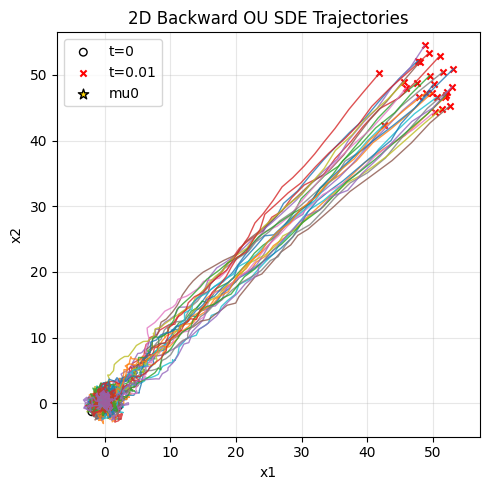

(array([[[ 3.04717183e-01, -1.03998400e+00],
         [ 7.50451299e-01,  9.40564819e-01],
         [-1.95103509e+00, -1.30217940e+00],
         ...,
         [ 1.16685912e-01,  2.18688700e-01],
         [ 8.71428881e-01,  2.23595652e-01],
         [ 6.78913666e-01,  6.75791725e-02]],
 
        [[ 4.02720977e-02, -1.22020862e+00],
         [ 5.44490036e-01,  3.93320132e-01],
         [-1.93804453e+00, -1.72801897e+00],
         ...,
         [ 3.69349619e-01, -4.23817147e-01],
         [ 1.26256394e+00,  3.52070363e-01],
         [ 5.55621979e-01,  8.22535723e-02]],
 
        [[-2.58689833e-01, -7.38064217e-01],
         [ 7.15420131e-01,  3.05776965e-01],
         [-1.94977973e+00, -1.72092342e+00],
         ...,
         [ 1.77866151e-01, -7.29253093e-01],
         [ 1.02226622e+00,  1.60275742e+00],
         [ 4.15151550e-01,  2.30211430e-01]],
 
        ...,
 
        [[ 4.20828881e+01,  4.63127125e+01],
         [ 4.57512537e+01,  4.07702975e+01],
         [ 4.16321648e+01,  4.3424

In [52]:
rng = np.random.default_rng(42)
mu_inf=np.array([0,0])

SDE_backward_2d(beta, sigma, rng,
                    T, dt,
                    mu0, C0,         
                    mu_inf,          
                    K_traj, N)

---

## 3. Forward ODE

1D PF-ODE:
$$\frac{dX_t}{dt}
= -\beta (X_t - \mu_\infty)
  + \frac{1}{2}\sigma^2\,\frac{(X_t - m_t)}{v_t}
$$

2D PF-ODE:
$$\boxed{
\frac{dX_t}{dt}
= -\beta (X_t - \mu_\infty)
  + \frac{1}{2}\sigma^2\,C_t^{-1}(X_t - m_t)
}$$

In [ ]:
def ODE_forward_2d(beta, sigma, rng,
                   T, dt,
                   mu0, C0,
                   mu_inf,
                   K_traj, N):

    steps = int(T/dt)

    x = rng.multivariate_normal(mu0, C0, size=N)

    traj_hist = [x[:K_traj].copy()]
    times = [0.0]

    # ====== 定義 m_t(t), C_t(t) ======
    def mean_t(t):
        return mu_inf + np.exp(-beta*t) * (mu0 - mu_inf)

    def cov_t(t):
        term1 = np.exp(-2*beta*t) * C0
        term2 = (sigma**2/(2*beta)) * (1 - np.exp(-2*beta*t)) * np.eye(2)
        return term1 + term2

    # ====== Time stepping ======
    for i in range(1, steps+1):

        # compute m_t, C_t, score term
        m_t = mean_t(i*dt)
        C_t = cov_t(i*dt)
        C_inv = np.linalg.inv(C_t)

        # score = -C^{-1}(x - m_t)
        score = - (x - m_t) @ C_inv.T

        # OU PF-ODE:
        # dx/dt = -beta (x - mu_inf) + 0.5 * sigma^2 * C^{-1} (x - m_t)
        drift = -beta*(x - mu_inf) + 0.5 * (sigma**2) * (-score)

        # Euler update
        x = x + drift * dt

        if i % max(1, steps//300) == 0:
            traj_hist.append(x[:K_traj].copy())
            times.append(i*dt)

    traj_hist = np.array(traj_hist)
    times = np.array(times)

    # ====== 畫圖 ======
    name="2D Forward PF ODE Trajectories"
    plot_2d(traj_hist, times, mu0, name)

    return traj_hist, times


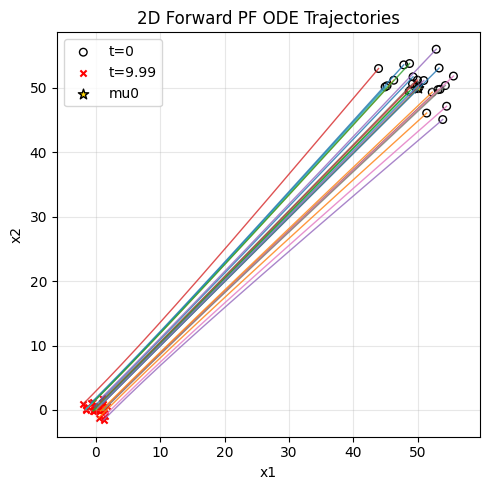

(array([[[49.2829043 , 51.735261  ],
         [46.28214672, 51.20556985],
         [48.86974674, 49.65544998],
         ...,
         [48.67600613, 49.45581982],
         [43.92339461, 53.02284309],
         [50.9442401 , 51.15994031]],
 
        [[46.39749912, 48.7212901 ],
         [43.55405738, 48.21936821],
         [46.0060015 , 46.75051395],
         ...,
         [45.82241782, 46.56134948],
         [41.31896373, 49.94137022],
         [47.97173877, 48.17613081]],
 
        [[43.68077708, 45.88433871],
         [40.98445062, 45.40838548],
         [43.30953495, 44.01552747],
         ...,
         [43.1354496 , 43.83615008],
         [38.86499726, 47.04129377],
         [45.17356801, 45.36738512]],
 
        ...,
 
        [[-0.22036144,  0.55591438],
         [-1.17022959,  0.38824447],
         [-0.35114348, -0.10243479],
         ...,
         [-0.41247067, -0.16562628],
         [-1.91687555,  0.9634892 ],
         [ 0.30552242,  0.37380076]],
 
        [[-0.22036144,  0.555

In [54]:
ODE_forward_2d(beta, sigma, rng,
                   T, dt,
                   mu0, C0,
                   mu_inf,
                   K_traj, N)

---

## 4. Backward ODE

1D:
  
2D:
$$
\frac{dX_t}{dt}
= +\beta (X_t - \mu_\infty)
  - \frac{1}{2}\sigma^2\,C_t^{-1}(X_t - m_t)
$$

In [60]:
def ODE_backward_2d(beta, sigma, rng,
                    T, dt,
                    mu0, C0,
                    mu_inf,
                    K_traj, N):

    steps = int(T/dt)

    # ===== 從 p_T 取樣 =====
    def mean_t(t):
        return mu_inf + np.exp(-beta*t) * (mu0 - mu_inf)

    def cov_t(t):
        term1 = np.exp(-2*beta*t) * C0
        term2 = (sigma**2/(2*beta)) * (1 - np.exp(-2*beta*t)) * np.eye(2)
        return term1 + term2

    mT = mean_t(T)
    CT = cov_t(T)
    x = rng.multivariate_normal(mT, CT, size=N)

    traj_hist = [x[:K_traj].copy()]
    times = [T]

    # ===== backward time stepping =====
    t = T
    for i in range(1, steps+1):

        mt = mean_t(t)
        Ct = cov_t(t)
        Ct_inv = np.linalg.inv(Ct)

        # backward PF-ODE drift:
        # dx/dt = +beta*(x - mu_inf) - 0.5*sigma^2*C^{-1}(x - m_t)
        drift = -beta*(x - mu_inf) + 0.5*(sigma**2)*( (x - mt) @ Ct_inv.T )

        x = x + drift * (-dt)   # 反向時間

        t -= dt
        traj_hist.append(x[:K_traj].copy())
        times.append(t)

    traj_hist = np.array(traj_hist)
    times = np.array(times)

    # ===== 畫圖 =====
    name="2D Backward PF ODE Trajectories"
    plot_2d(traj_hist, times, mu_inf, name)

    return traj_hist, times


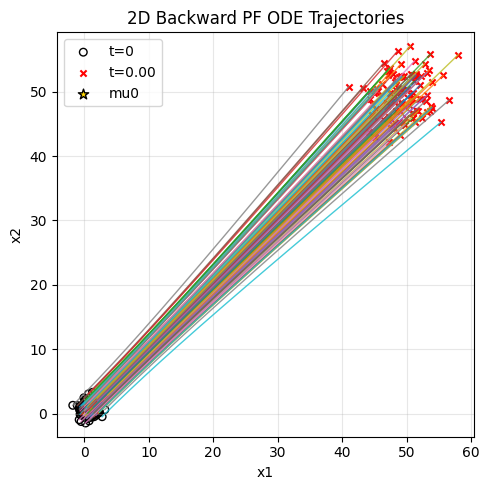

(array([[[ 1.53192685,  1.85328323],
         [ 2.20007452,  2.14658082],
         [ 0.17220945,  2.15178776],
         ...,
         [ 0.1029397 ,  0.36142276],
         [ 1.96531902,  2.44134781],
         [ 2.32181246,  0.26868246]],
 
        [[ 1.54110322,  1.86246927],
         [ 2.209271  ,  2.15577569],
         [ 0.18134489,  2.16098279],
         ...,
         [ 0.11207305,  0.37056389],
         [ 1.97450844,  2.45055155],
         [ 2.33101261,  0.2778208 ]],
 
        [[ 1.55037199,  1.87174791],
         [ 2.21856029,  2.16506334],
         [ 0.19057191,  2.1702706 ],
         ...,
         [ 0.12129795,  0.37979673],
         [ 1.98379052,  2.45984825],
         [ 2.34030564,  0.28705079]],
 
        ...,
 
        [[50.45812852, 51.44695356],
         [52.51404276, 52.34944073],
         [46.27422959, 52.36546267],
         ...,
         [46.06108409, 46.85644568],
         [51.79169171, 53.25644926],
         [52.88863474, 46.57108048]],
 
        [[50.96120864, 51.958

In [65]:
K_traj=100
ODE_backward_2d(beta, sigma, rng,
                    T, dt,
                    mu0, C0,
                    mu_inf,
                    K_traj, N)